In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm

# Dataset Description

The dataset I used for this tutorial is from Kaggle Dataset( https://www.kaggle.com/CooperUnion/cardataset) This cars dataset includes features such as make, model, year, engine, and other properties of the car. We will use these features to generate the word embeddings for each make model and then compare the similarities between different make model. The following dataframe shows the detail information of this dataset.

In [4]:
df = pd.read_csv('data (1).csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


# Data Preprocessing

1. Create a new column for Make Model

In [5]:
df['Maker_Model']= df['Make']+ " " + df['Model']

2. Generate a format of list of list for each Make Model

In [6]:
# Select features from original dataset to form a new dataframe
df1 = df[['Engine Fuel Type','Transmission Type','Driven_Wheels','Market Category','Vehicle Size', 'Vehicle Style', 'Maker_Model']]
# For each row, combine all the columns into one column
# separator.join(iterabable) method is used to make a single string from all cols
df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1)
# Store them in the pandas dataframe
# creates a new dataframe df_clean with a single column 'clean' that contains the combined strings.
df_clean = pd.DataFrame({'clean': df2})
# Create the list of list format of the custom corpus for gensim modeling
sent = [row.split(',') for row in df_clean['clean']]
# show the example of list of list format of the custom corpus for gensim modeling
sent

[['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Factory Tuner',
  'Luxury',
  'High-Performance',
  'Compact',
  'Coupe',
  'BMW 1 Series M'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'Performance',
  'Compact',
  'Convertible',
  'BMW 1 Series'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'High-Performance',
  'Compact',
  'Coupe',
  'BMW 1 Series'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'Performance',
  'Compact',
  'Coupe',
  'BMW 1 Series'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'Compact',
  'Convertible',
  'BMW 1 Series'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'Performance',
  'Compact',
  'Coupe',
  'BMW 1 Series'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'Performance',
  'Compact',
  'Convertible',
  'BMW 1 Serie

# Genism word2vec Model Training

In [9]:
## Train the genisim word2vec model with our own custom corpus
#  the number of worker threads to use for training the model. Using multiple threads can speed up the training process by parallelizing computations.
# window=3: This parameter sets the maximum distance between the current and predicted word within a sentence. 
# A window=3 means that the context window size is 3 words to the left and 3 words to the right of the target word.
# sg=1: This parameter specifies the training algorithm. If sg=1, the Skip-Gram model is used. If sg=0, the Continuous Bag of Words (CBOW) model is used. 
# The Skip-Gram model aims to predict the context words given a target word, whereas CBOW predicts the target word given context words.
model = Word2Vec(sent, min_count=1, vector_size= 50,workers=3, window =3, sg = 1);

INFO - 17:05:03: collecting all words and their counts
INFO - 17:05:03: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:05:03: PROGRESS: at sentence #10000, processed 74060 words, keeping 841 word types
INFO - 17:05:03: collected 977 word types from a corpus of 88129 raw words and 11914 sentences
INFO - 17:05:03: Creating a fresh vocabulary
INFO - 17:05:03: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 977 unique words (100.00% of original 977, drops 0)', 'datetime': '2024-06-22T17:05:03.992886', 'gensim': '4.3.0', 'python': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
INFO - 17:05:04: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 88129 word corpus (100.00% of original 88129, drops 0)', 'datetime': '2024-06-22T17:05:04.000890', 'gensim': '4.3.0', 'python': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec

In [8]:
## We can obtain the word embedding directly from the training model
model.wv['Toyota Camry']

array([ 0.01434744,  0.10643212,  0.00610376, -0.10637471, -0.07455156,
       -0.19264168,  0.01129327,  0.25379077, -0.10021337, -0.07533785,
        0.0456644 ,  0.02753936,  0.11665571, -0.03060157, -0.03855447,
        0.15621613,  0.11609697,  0.23637384, -0.10155064, -0.29026493,
       -0.0570108 , -0.05177353,  0.22359264,  0.07045104,  0.11559859,
       -0.01083965, -0.01490044,  0.31694123, -0.02997061,  0.01642603,
        0.04072579,  0.01582605,  0.04170388,  0.02336644,  0.0725218 ,
       -0.09907348,  0.17174162, -0.04889355,  0.01259262,  0.04721098,
        0.07507556, -0.02111054, -0.18249424,  0.09637495,  0.31125093,
        0.0432706 ,  0.02837705, -0.15546422, -0.01535915,  0.02503375],
      dtype=float32)

# Compare Similarities

In [10]:
model.wv.similarity('Porsche 718 Cayman', 'Nissan Van')

0.8451206

In [11]:
model.wv.similarity('Porsche 718 Cayman', 'Mercedes-Benz SLK-Class')

0.94436675

In [12]:
## Show the most similar vehicles for Mercedes-Benz SLK-Class : Default by eculidean distance
model.wv.most_similar('Mercedes-Benz SLK-Class')[:5]

[('Audi S3', 0.988365113735199),
 ('Scion FR-S', 0.9856348633766174),
 ('Ford Mustang SVT Cobra', 0.9845156669616699),
 ('Subaru BRZ', 0.9844591617584229),
 ('Subaru SVX', 0.9838390350341797)]

In [13]:
## Show the most similar vehicles for Toyota Camry : Default by eculidean distance
model.wv.most_similar('Toyota Camry')[:5]

[('Kia Optima', 0.9861916899681091),
 ('Oldsmobile Eighty-Eight Royale', 0.9843465685844421),
 ('Nissan Altima', 0.9831764101982117),
 ('Toyota Avalon', 0.9829505085945129),
 ('Dodge Dart', 0.9818565249443054)]

In [14]:
# Cosine similarity gives similarity based on angles between vectors
# dot product of vectors divided by magnitude
# normalizae to make it range ffrom 0-1
def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model.wv[word]
    for item in target_list :
        if item != word :
            b = model.wv[item]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

In [15]:
Maker_Model = list(df.Maker_Model.unique()) ## only get the unique Maker_Model_Year
## Show the most similar Mercedes-Benz SLK-Class by cosine distance
cosine_distance (model,'Mercedes-Benz SLK-Class',Maker_Model,5)

[('Audi S3', 0.9883651),
 ('Scion FR-S', 0.98563486),
 ('Ford Mustang SVT Cobra', 0.98451567),
 ('Subaru BRZ', 0.98445916),
 ('Subaru SVX', 0.98383915)]

# T-SNE Plot

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def display_closestwords_tsnescatterplot(model, word, size=100):
    """
    Plots a 2D t-SNE scatter plot of the given word and its closest words in the vector space.

    Parameters:
    model (gensim.models.Word2Vec): Trained Word2Vec model.
    word (str): The target word to visualize.
    size (int): Size of the word vectors.
    """
    if word not in model.wv:
        print(f"Word '{word}' not in vocabulary.")
        return

    arr = np.empty((0, size), dtype='f')
    word_labels = [word]

    try:
        close_words = model.wv.similar_by_word(word)
    except KeyError:
        print(f"Word '{word}' not in model vocabulary.")
        return

    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    num_samples = len(word_labels)
    perplexity = min(30, num_samples - 1)

    if num_samples <= 1:
        print("Not enough data points to plot.")
        return

    print(f"Number of samples: {num_samples}, Perplexity: {perplexity}")

    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    # Adjust the limits slightly for better visualization
    margin = 0.05
    plt.xlim(x_coords.min() - margin, x_coords.max() + margin)
    plt.ylim(y_coords.min() - margin, y_coords.max() + margin)
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.title(f"t-SNE visualization for '{word}' and closest words")
    plt.show()


Number of samples: 11, Perplexity: 10


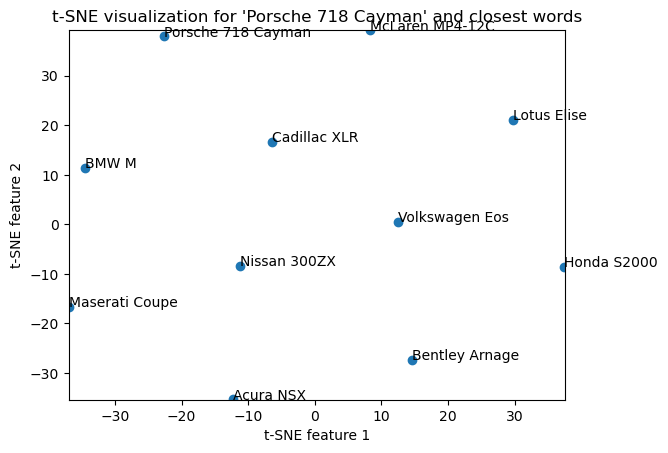

In [17]:
display_closestwords_tsnescatterplot(model, 'Porsche 718 Cayman', 50)